### Analyze dataset used for mrl compositionality task

In [ ]:
# import mrna_bench as mb
# dataset = mb.load_dataset("mrl-sample-egfp")
# data_df = dataset.data_df
# TODO: switch to normal download once this is on hugging face
from mrna_bench.datasets.mrl_sample import MRLSampleEGFP
mrl = MRLSampleEGFP(force_redownload=True)
data_df = mrl.data_df


No HF URL provided. Processing from raw.


100%|██████████| 431M/431M [00:45<00:00, 9.39MB/s] 


Extracting data...
Processing data...


In [2]:
data_df.head(1)

,sequence,cds,splice,target_mrl_egfp_m1pseudo,target_mrl_egfp_pseudo,target_mrl_egfp_unmod,u_start,u_oof_start,kozak_quality
0,GGGACATCGTAGAGAGTCGTACTTACCACTCGATTAACATGTTAAC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.643867,3.333217,2.864254,1,1,mixed


### Visualize the mrls for different feature combinations of kozak quality and upstream start codon presence


Mean mrls:
 feature_combo
u_start :0,\nstrong kozak    6.720186
u_start :0,\nweak kozak      6.218298
u_start :1,\nstrong kozak    5.304816
u_start :1,\nweak kozak      5.028797
Name: target_mrl_egfp_m1pseudo, dtype: float64


/tmp/ipykernel_420149/3036454258.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['feature_combo'] = subset_df.apply(
/tmp/ipykernel_420149/3036454258.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


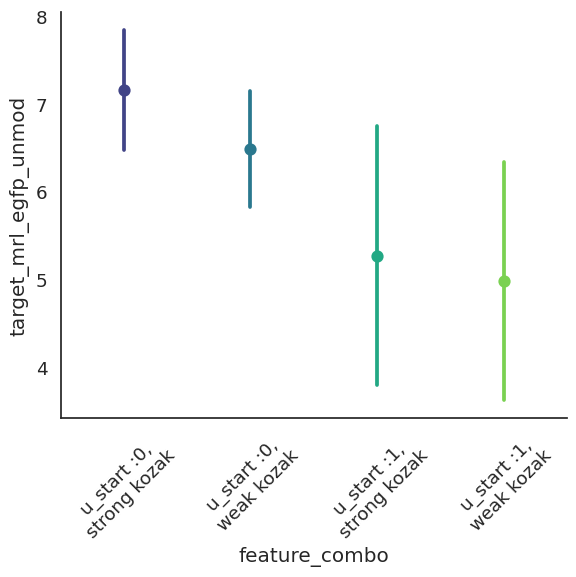

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

subset_df = data_df[data_df['kozak_quality'] != 'mixed']
# Create a new column with the combination labels
subset_df['feature_combo'] = subset_df.apply(
    lambda row: f"u_start :{row['u_start']},\n{row['kozak_quality']} kozak",
    #lambda row: f"oof start:{row['oof_start']},\n{'good' if row['canonical_kozak'] else 'bad'} kozak",
    axis=1
)

# Sort combos by mean MRL for nicer ordering
mean_mrls = subset_df.groupby('feature_combo')['target_mrl_egfp_m1pseudo'].mean().sort_values(ascending=False)
print("Mean mrls:\n", mean_mrls)
ordered_combos = mean_mrls.index.tolist()

# Set up the plot
plt.figure(figsize=(6, 6))
sns.set(style="white", font_scale=1.2)

# Use boxplot (or use sns.barplot for mean + CI)
sns.pointplot(
    x='feature_combo',
    y='target_mrl_egfp_unmod',
    data=subset_df,
    order=ordered_combos,
    palette="viridis",
    errorbar='sd'
)

# plt.xlabel("Feature Combination (u_start, oof_start, canonical_kozak)")
plt.ylabel("target_mrl_egfp_unmod")
plt.xticks(rotation=45)
sns.despine()  # removes top and right spines
plt.tight_layout()
plt.show()


In [4]:
subset_df['feature_combo'].value_counts().sort_index()

feature_combo
u_start :0,\nstrong kozak    35534
u_start :0,\nweak kozak       2533
u_start :1,\nstrong kozak    38810
u_start :1,\nweak kozak       5043
Name: count, dtype: int64

In [5]:
from itertools import combinations
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# All unique pairs
combos = subset_df['feature_combo'].unique()
pairs = list(combinations(combos, 2))

# Perform t-tests
results = []
for a, b in pairs:
    group_a = subset_df[subset_df['feature_combo'] == a]['target_mrl_egfp_unmod']
    group_b = subset_df[subset_df['feature_combo'] == b]['target_mrl_egfp_unmod']
    stat, pval = ttest_ind(group_a, group_b, equal_var=False)
    results.append((a, b, pval))

# Multiple testing correction
pvals = [x[2] for x in results]
reject, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')

# Create a significance table
sig_results = pd.DataFrame(results, columns=['Group1', 'Group2', 'raw_pval'])
sig_results['adj_pval'] = pvals_corrected
sig_results['significant'] = reject

# Show significant comparisons only
sig_results = sig_results[sig_results['significant']].sort_values('adj_pval')

print("Significant pairwise comparisons (FDR-adjusted):")
print(sig_results[['Group1', 'Group2', 'adj_pval']])

Significant pairwise comparisons (FDR-adjusted):
                      Group1                     Group2      adj_pval
0  u_start :1,\nstrong kozak  u_start :0,\nstrong kozak  0.000000e+00
2  u_start :1,\nstrong kozak    u_start :0,\nweak kozak  0.000000e+00
3  u_start :0,\nstrong kozak    u_start :1,\nweak kozak  0.000000e+00
4  u_start :0,\nstrong kozak    u_start :0,\nweak kozak  0.000000e+00
5    u_start :1,\nweak kozak    u_start :0,\nweak kozak  0.000000e+00
1  u_start :1,\nstrong kozak    u_start :1,\nweak kozak  6.382378e-43
